In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


def create_dataframe():
	# initialize db connection and session
	db_engine, db_session = init_db()

	# query data from the database
	query = db_session.query(
		RacingWeekend.year,
		RacingWeekend.round,
		Circuit.circuit_name,
		Driver.driver_name,
		Driver.driver_short,
		Lap.lap_num,
		Lap.lap_time,
		Lap.tyre,
		Lap.tyre_laps,
		Lap.pit,
		Session.session_type
	).join(RacingWeekend.circuit) \
	 .join(RacingWeekend.sessions) \
	 .join(Session.laps) \
	 .join(Lap.driver) \
	 .join(RacingWeekend.season) \
	 .all()

	# convert result to list of dicts
	data = []
	for row in query:
		data.append({
			'year': row.year,
			'round': row.round,
			'circuit_name': row.circuit_name,
			'driver_name': row.driver_name,
			'driver_short': row.driver_short,
			'lap_num': row.lap_num,
			'lap_time': row.lap_time,
			'tyre': row.tyre,
			'tyre_laps': row.tyre_laps,
			'pit': row.pit,
			'session_type': row.session_type
		})

	# create dataframe
	df = pd.DataFrame(data)


	return df


def correct_fuel_effect(df, year, race_round, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	# Adjust lap times in a race for the effect of fuel weight
	race_df = df[(df['year'] == year) & (df['round'] == race_round) & (df['session_type'] == "Race")].copy()
	max_laps = race_df['lap_num'].max()
	race_df['fuel_weight'] = max_fuel_kg - (race_df['lap_num'] - 1) * (max_fuel_kg / max_laps)
	race_df['fuel_correction'] = race_df['fuel_weight'] * fuel_effect_per_kg
	race_df['fuel_corrected_lap_time'] = race_df['lap_time'] - race_df['fuel_correction']
	return race_df

def assign_stint_numbers(df):
	# Assign stint numbers to laps based on pit stops for each driver
	df['stint'] = np.nan
	for driver in df['driver_short'].unique():
		driver_data = df[df['driver_short'] == driver]
		stint_number = 1
		for i in driver_data.index:
			if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
				stint_number += 1
			df.loc[i, 'stint'] = stint_number
	df['stint'] = df['stint'].astype(int)
	return df

def get_last_10_races_from_round(df, year, round_):
	# Get the last 10 unique races starting from a given year and round
	df_unique = df.drop_duplicates(subset=['year', 'round'])
	filtered_df = df_unique[
		(df_unique['year'] < year) | 
		((df_unique['year'] == year) & (df_unique['round'] <= round_))
	]
	df_sorted = filtered_df.sort_values(by=['year', 'round'], ascending=[False, False])
	last_10_races = df_sorted[['year', 'round']].head(30)
	return last_10_races

def analyze_and_average_polynomials(df, driver, current_year, current_round):
	# Get the last 10 races starting from the current race
	last_10_races = get_last_10_races_from_round(df, current_year, current_round)
	
	# Store polynomial coefficients for each tyre type across races
	tyre_poly_coeffs = {tyre: [] for tyre in df['tyre'].unique()}
	
	# Loop through each race in the last 10 races
	for _, race in last_10_races.iterrows():
		year = race['year']
		round_ = race['round']
		
		# Filter the DataFrame for the specific race and driver
		race_df = df[(df['year'] == year) & (df['round'] == round_) & (df['driver_short'] == driver)].copy()
		
		# Correct for fuel effect
		race_df = correct_fuel_effect(race_df, year, round_)
		
		# Normalize lap times based on the fastest lap and filter out outliers
		fastest_lap_time = race_df['fuel_corrected_lap_time'].min()
		race_df = race_df[race_df['fuel_corrected_lap_time'] <= 1.03 * fastest_lap_time]  # Filter out lap times more than 7% slower
		
		# Calculate the difference from the fastest lap for each lap
		race_df['time_diff'] = race_df['fuel_corrected_lap_time'] - fastest_lap_time
		
		# Assign stint numbers
		race_df = assign_stint_numbers(race_df)
		
		# Loop over each tyre type and perform polynomial regression for each stint
		for tyre in race_df['tyre'].unique():
			tyre_data = race_df[race_df['tyre'] == tyre]
			
			# Loop through each stint for the given tyre type
			for stint in tyre_data['stint'].unique():
				stint_data = tyre_data[tyre_data['stint'] == stint]
				x = stint_data['lap_num']
				y = stint_data['time_diff']
				
				# Polynomial regression (2nd degree)
				if len(x) > 2:
					poly_coeffs = np.polyfit(x, y, 2)
					tyre_poly_coeffs[tyre].append(poly_coeffs)
	
	# Average the polynomial coefficients for each tyre type across all races
	averaged_poly_coeffs = {}
	for tyre, poly_coeffs_list in tyre_poly_coeffs.items():
		if poly_coeffs_list:
			avg_poly_coeffs = np.mean(poly_coeffs_list, axis=0)
			averaged_poly_coeffs[tyre] = avg_poly_coeffs
	
	# Return the averaged polynomial equations for each tyre type
	polynomial_equations = {}
	for tyre, coeffs in averaged_poly_coeffs.items():
		equation = f"{coeffs[0]:.3f}x^2 + {coeffs[1]:.3f}x + {coeffs[2]:.3f}"
		polynomial_equations[tyre] = equation
	
	return averaged_poly_coeffs




def get_qualifying_to_race_percentage_difference(df, driver, year, round_, n_races=10):
	"""
	Calculate the average percentage difference between the best qualifying lap time and best race lap time
	over the last `n_races` for the given driver.

	Args:
		df (DataFrame): The dataframe containing race and qualifying data.
		driver (str): The driver's name or short identifier.
		year (int): The year of the races.
		round_ (int): The current race round.
		n_races (int): The number of past races to consider (default 10).

	Returns:
		float: The average percentage difference between qualifying and race lap times.
	"""
	# Get all races for the given driver, within the last `n_races` rounds
	races_df = df[(df['year'] == year) & (df['driver_short'] == driver)].copy()
	
	# Limit to the last `n_races`
	races_df = races_df[races_df['round'] <= round_].tail(n_races)

	percentage_diffs = []

	for _, race in races_df.iterrows():
		# Get best qualifying lap time for the driver in this round
		quali_df = df[(df['year'] == race['year']) & 
					  (df['round'] == race['round']) & 
					  (df['driver_short'] == driver) & 
					  (df['session_type'] == 'Qualifying')]
		fastest_quali_time = quali_df['lap_time'].min() if not quali_df.empty else None

		# Get best race lap time for the driver in this round
		race_df = df[(df['year'] == race['year']) & 
					 (df['round'] == race['round']) & 
					 (df['driver_short'] == driver) & 
					 (df['session_type'] == 'Race')]
		fastest_race_time = race_df['lap_time'].min() if not race_df.empty else None

		# If both quali and race lap times are available, calculate the percentage difference
		if fastest_quali_time and fastest_race_time:
			diff = (fastest_race_time - fastest_quali_time) / fastest_quali_time * 100
			percentage_diffs.append(diff)

	# Return the average percentage difference, or 0 if no valid data
	return np.mean(percentage_diffs) if percentage_diffs else 0



def predict_lap_time(df, driver, year, round_, polynomial_equations, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	# Get the race data for the given driver and race
	race_df = df[(df['year'] == year) & (df['round'] == round_) & (df['driver_short'] == driver) & (df['session_type'] == 'Race')].copy()

	# Get the best qualifying lap time for the driver in the same round
	quali_df = df[(df['year'] == year) & (df['round'] == round_) & (df['driver_short'] == driver) & (df['session_type'] == 'Qualifying')].copy()
	fastest_quali_time = quali_df['lap_time'].min() if not quali_df.empty else None

	if fastest_quali_time is None:
		raise ValueError(f"No qualifying lap time found for driver {driver} in {year} round {round_}")

	# Get the average percentage difference between quali and race times over the last 10 races
	avg_percentage_diff = get_qualifying_to_race_percentage_difference(df, driver, year, round_)

	# Adjust the fastest qualifying time based on the average percentage difference
	base_laptime = fastest_quali_time * (1 + avg_percentage_diff / 100)

	max_laps = race_df['lap_num'].max()
	race_df['fuel_weight'] = max_fuel_kg - (race_df['lap_num'] - 1) * (max_fuel_kg / max_laps)
	race_df['fuel_correction'] = race_df['fuel_weight'] * fuel_effect_per_kg

	# Iterate through each lap in the race
	predicted_lap_times = []
	for index, row in race_df.iterrows():
		# Get the tire type and laps on the tire for the current lap
		tyre_type = row['tyre']
		tyre_laps = row['tyre_laps']  # Number of laps the driver has been on this tire
		
		# Check if a polynomial equation exists for this tire type
		if tyre_type in polynomial_equations:

			# Use the polynomial equation to predict the time difference from the fastest lap for the given number of laps
			predicted_time_diff = np.polyval(polynomial_equations[tyre_type], tyre_laps)

			predicted_time = predicted_time_diff + row['fuel_correction'] + base_laptime
			race_df.at[index, 'predicted_time'] = predicted_time
			

	return race_df
	


# Example usage
df = create_dataframe()

# Load polynomial equations for the driver (from analyze_and_average_polynomials function)
polynomial_equations = analyze_and_average_polynomials(df, driver='NOR', current_year=2023, current_round=11)
print(polynomial_equations)
# Predict lap times for the 2023, round 23 for the driver
predicted_lap_times = predict_lap_time(df, driver='NOR', year=2023, round_=13, polynomial_equations=polynomial_equations)

# Print the predicted lap times for the 23rd race
predicted_lap_times


{np.int64(1): array([ 6.09918061e-03, -3.05642172e-01,  7.81302362e+00]), np.int64(2): array([ 9.47306223e-04,  7.94447716e-02, -2.31769133e+00]), np.int64(3): array([ 2.44123623e-03, -1.91411147e-01,  5.00082063e+00]), np.int64(4): array([-0.01287236,  0.58036809, -3.52649127])}


,year,round,circuit_name,driver_name,driver_short,lap_num,lap_time,tyre,tyre_laps,pit,session_type,fuel_weight,fuel_correction,predicted_time
221801,2023,13,Zandvoort,Lando Norris,NOR,1,92.227,1,1,False,Race,110.000000,3.300000,85.203481
221802,2023,13,Zandvoort,Lando Norris,NOR,2,107.848,1,2,False,Race,108.472222,3.254167,84.870303
221803,2023,13,Zandvoort,Lando Norris,NOR,3,115.144,1,3,False,Race,106.944444,3.208333,84.549323
221804,2023,13,Zandvoort,Lando Norris,NOR,4,107.537,4,1,True,Race,105.416667,3.162500,74.593504
221805,2023,13,Zandvoort,Lando Norris,NOR,5,83.686,4,2,False,Race,103.888889,3.116667,75.089422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221866,2023,13,Zandvoort,Lando Norris,NOR,68,84.530,4,16,False,Race,7.638889,0.229167,77.083240
221867,2023,13,Zandvoort,Lando Norris,NOR,69,82.506,4,17,False,Race,6.111111,0.183333,77.192987
221868,2023,13,Zandvoort,Lando Norris,NOR,70,82.490,4,18,False,Race,4.583333,0.137500,77.276989
221869,2023,13,Zandvoort,Lando Norris,NOR,71,82.130,4,19,False,Race,3.055556,0.091667,77.335246


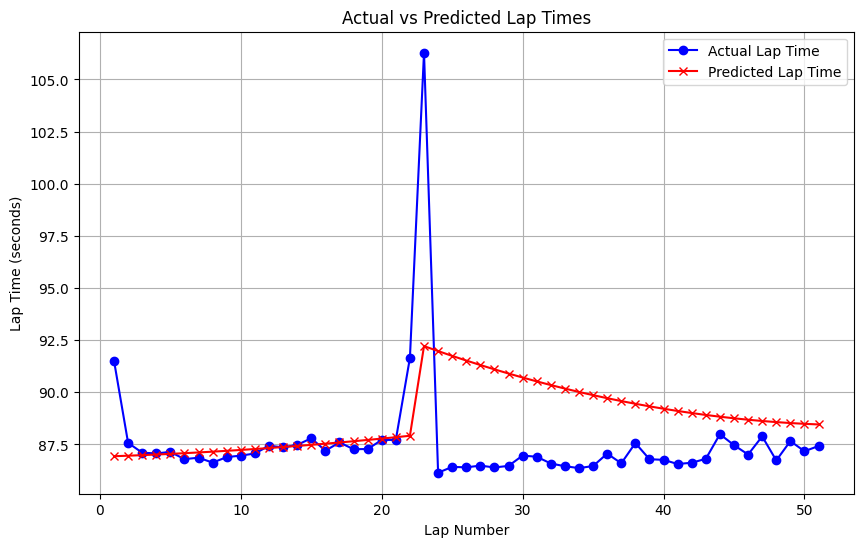

In [14]:
import matplotlib.pyplot as plt

def plot_lap_times(race_df):
	# Plotting actual vs predicted lap times
	plt.figure(figsize=(10, 6))

	# Plot actual lap times
	plt.plot(race_df['lap_num'], race_df['lap_time'], label='Actual Lap Time', color='blue', marker='o')

	# Plot predicted lap times
	plt.plot(race_df['lap_num'], race_df['predicted_time'], label='Predicted Lap Time', color='red', marker='x')

	# Adding labels and title
	plt.xlabel('Lap Number')
	plt.ylabel('Lap Time (seconds)')
	plt.title('Actual vs Predicted Lap Times')
	
	# Add legend
	plt.legend()

	# Show the plot
	plt.grid(True)
	plt.show()

# Example usage
df = create_dataframe()

# Load polynomial equations for the driver (from analyze_and_average_polynomials function)
polynomial_equations = analyze_and_average_polynomials(df, driver='NOR', current_year=2023, current_round=13)

# Predict lap times for the 2023, round 13 for the driver
predicted_lap_times = predict_lap_time(df, driver='NOR', year=2023, round_=14, polynomial_equations=polynomial_equations)

# Plot the actual and predicted lap times
plot_lap_times(predicted_lap_times)


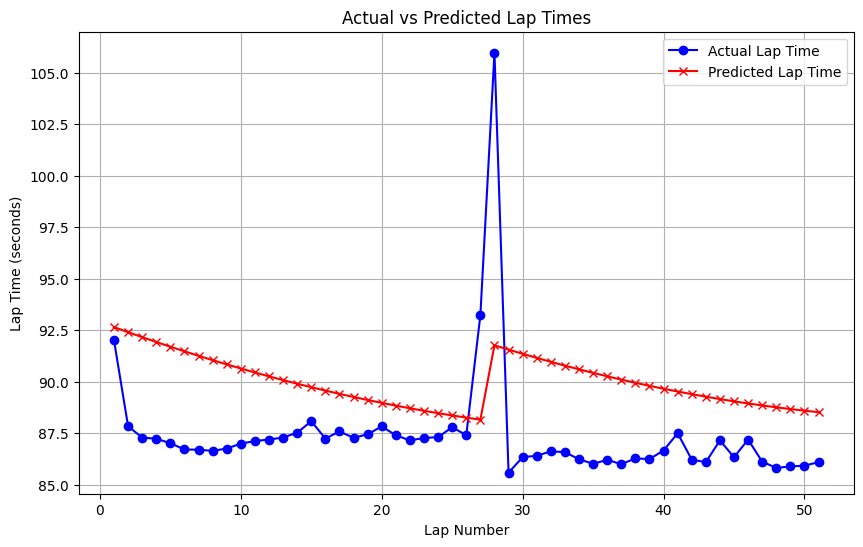

In [15]:
import matplotlib.pyplot as plt

def plot_lap_times(race_df):
	# Plotting actual vs predicted lap times
	plt.figure(figsize=(10, 6))

	# Plot actual lap times
	plt.plot(race_df['lap_num'], race_df['lap_time'], label='Actual Lap Time', color='blue', marker='o')

	# Plot predicted lap times
	plt.plot(race_df['lap_num'], race_df['predicted_time'], label='Predicted Lap Time', color='red', marker='x')

	# Adding labels and title
	plt.xlabel('Lap Number')
	plt.ylabel('Lap Time (seconds)')
	plt.title('Actual vs Predicted Lap Times')
	
	# Add legend
	plt.legend()

	# Show the plot
	plt.grid(True)
	plt.show()

# Example usage
df = create_dataframe()

# Load polynomial equations for the driver (from analyze_and_average_polynomials function)
polynomial_equations = analyze_and_average_polynomials(df, driver='HAM', current_year=2023, current_round=13)

# Predict lap times for the 2023, round 13 for the driver
predicted_lap_times = predict_lap_time(df, driver='HAM', year=2023, round_=14, polynomial_equations=polynomial_equations)

# Plot the actual and predicted lap times
plot_lap_times(predicted_lap_times)


[np.float64(5922.365), np.float64(5024.168999999999), np.float64(5942.0869999999995), np.float64(4466.592000000001), np.float64(6216.919), np.float64(4974.785), np.float64(5265.137), np.float64(5732.092000000001), np.float64(6044.327000000001), np.float64(5490.728000000001)]
[np.float64(5910.616442896416), np.float64(5162.26611670997), np.float64(5576.987070981512), np.float64(4527.315535569702), np.float64(6162.835465825871), np.float64(4965.3020494217835), np.float64(5032.1391268532525), np.float64(5793.894371771115), np.float64(5978.204276546404), np.float64(5407.997362019592)]


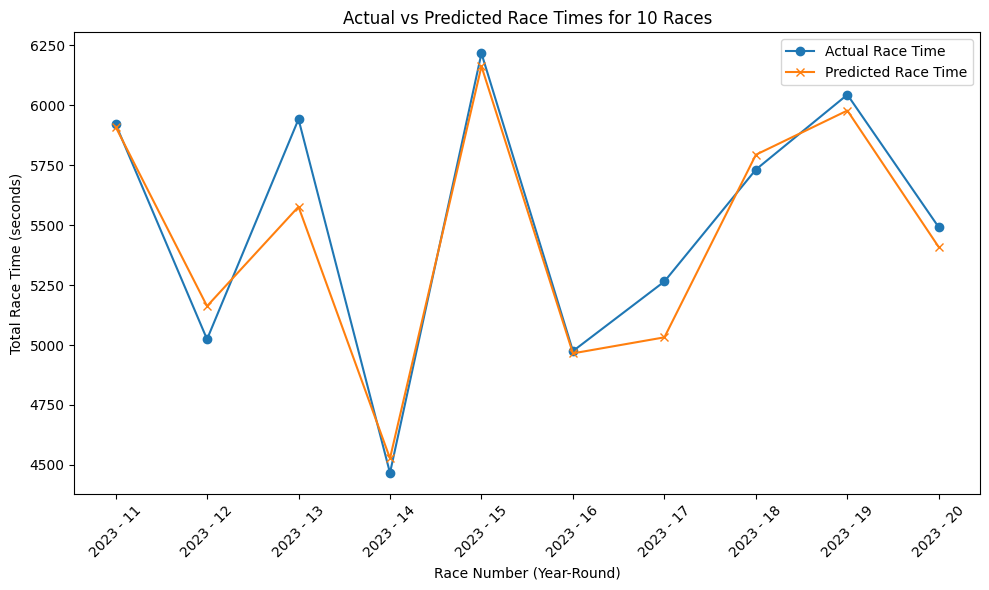

In [16]:
import matplotlib.pyplot as plt

def predict_lap_time_for_multiple_races(df, start_year, start_round, polynomial_equations, n_races=10):

	# List to store actual and predicted times for each race
	actual_times = []
	predicted_times = []
	race_numbers = []

	current_year = start_year
	current_round = start_round

	# Loop through each race from start_year, start_round for n_races races
	for race in range(n_races):
		polynomial_equations = analyze_and_average_polynomials(df, driver='NOR', current_year=current_year, current_round=current_round-1)

		# Filter race data
		race_df = df[(df['year'] == current_year) & (df['round'] == current_round) & (df['session_type'] == 'Race') & (df['driver_short'] == "NOR")]

		if race_df.empty:
			print(f"No race data found for {current_year} round {current_round}. Skipping.")
			continue

		# Get the actual lap times
		actual_race_time = race_df['lap_time'].sum()  # sum of lap times for the race

		# Predict lap times using the polynomial equations
		predicted_race_df = predict_lap_time(df, driver='NOR', year=current_year, round_=current_round, polynomial_equations=polynomial_equations)
		predicted_race_time = predicted_race_df['predicted_time'].sum()  # sum of predicted lap times for the race

		# Append actual and predicted times to the lists
		actual_times.append(actual_race_time)
		predicted_times.append(predicted_race_time)
		race_numbers.append(f"{current_year} - {current_round}")

		# Update for the next race
		current_round += 1
		if current_round > 23:  # If we reach beyond round 23, move to the next season
			current_round = 1
			current_year += 1

	return race_numbers, actual_times, predicted_times


# Test the method and plot
race_numbers, actual_times, predicted_times = predict_lap_time_for_multiple_races(df, start_year=2023, start_round=11, polynomial_equations=polynomial_equations)


print(actual_times)
print(predicted_times)
# Plot the total actual vs predicted race times
plt.figure(figsize=(10, 6))
plt.plot(race_numbers, actual_times, label='Actual Race Time', marker='o')
plt.plot(race_numbers, predicted_times, label='Predicted Race Time', marker='x')
plt.xlabel('Race Number (Year-Round)')
plt.ylabel('Total Race Time (seconds)')
plt.title('Actual vs Predicted Race Times for 10 Races')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
